In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler
from class_vehicle_data import Vehicle_data

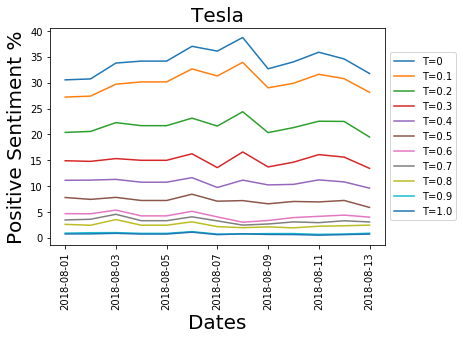

In [7]:
output = ["output_t0","output_t10","output_t20","output_t30","output_t40","output_t50","output_t60","output_t70","output_t80","output_t90","output_t100"]
thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
car_company = ["BMW","Ford","Mercedes","Porsche","Tesla","Toyota"]


# Initialize all car data
all_cars = [Vehicle_data() for k in range(len(output))]

# The car we want to focus on
target_car=car_company[4]

# Read in all the data for a specific vehicle
for k in range(len(all_cars)):
    file = "data/"+output[k]+"/"+target_car+"_daily_data.txt"
    threshold = thresholds[k]
    car = all_cars[k]
    car.read_in_data(file)
    car.fill_NA()
    y_pos, y_neg, y_neu = car.return_sentiment_data()
    #y_pos,y_neg,y_neu =car.scale_data_Ztransform()
    #y_pos,y_neg,y_neu =car.scale_data_MinMaxTransform(Xmin=-1,Xmax=1)
    plt.plot(car.car_data["Dates"],y_pos,label="T="+str(threshold))
    
plt.title(target_car,size=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation='vertical')
plt.xlabel("Dates",size=20)
plt.ylabel("Positive Sentiment %",size=20)
plt.show()

# We will combine all curves for different thresholds          
 
 
<p></p>

<font size="3">
   
In order to combine the curves $\hat{y}(x)$ with different thresholds, we will compute the expectation value of a curve $\hat{y}(x)$, which is either the negative or positive sentiment curves, given that $y=\hat{y}$ (ie. that the estimate $\hat{y}$ is the same as the true value $y$). The marginalization of the different curves, goes as follows

\begin{align}
\langle \hat{y}(x) \rangle &= \int dT \ \hat{y}(x,T) P(\hat{y},y=\hat{y},T) \\
&= \int dT \ \hat{y}(x,T)P(\hat{y}|y=\hat{y},T) P(y=\hat{y},T) \\
&= \int dT \ \hat{y}(x,T)P(\hat{y}|y=\hat{y},T) P(y=\hat{y}|T)P(T)  
\end{align}

For the puposes of our analysis, we will assume a uniform probablity distribution for $T$. 

---
---

To better understand this formula, we will explicitly write out the integral over $T$ for both the positive $\text{Pos}(x)$ and negative $\text{Neg}(x)$ curves and discuss the individual probabilitiy density functions in the integrand


\begin{align}
\langle \text{TruePos}(x) \rangle &= \int dT \ \text{Pos}(x,T)P(\hat{y}=1|y=1,T) P(y=1|T)P(T)  \\
\langle \text{FalsePos}(x) \rangle &= \int dT \ \text{Pos}(x,T)P(\hat{y}=1|y=0,T) P(y=0|T)P(T)   
\end{align}

---

\begin{align}
\langle \text{TrueNeg}(x) \rangle  &= \int dT \ \text{Neg}(x,T)P(\hat{y}=-1|y=-1,T) P(y=-1|T)P(T) \\
\langle \text{FalseNeg}(x) \rangle &= \int dT \ \text{Neg}(x,T)P(\hat{y}=-1|y=1,T) P(y=1|T)P(T)
\end{align}




The probability $P(\hat{y}=1|y=1,T)$ is the probability of the model classifying the sentiment as positive, given that the real sentiment is also positive, for a given threshold. This is known as the precision of the classifier.

The probability $P(y=1|T)$ is simply the probability that a given sentiment is positive, given a value of T. 


Similarly, $P(\hat{y}=-1|y=-1,T)$ is the probability of the model classifying the sentiment as negative, given that the real sentiment is also negative, for a given threshold and $P(y=-1|T)$ is the probability that a given sentiment is negative, given a value of T.


---
---

## Assumptions

In order to carry out this analysis, we will assume that the probability densities, $P(\hat{y}=1|y=1,T),P(\hat{y}=-1|y=-1,T)$  and  $P(y=1|T),P(y=-1|T)$ are the same as the values from when we tested our models on the labelled twitter data.


</font>

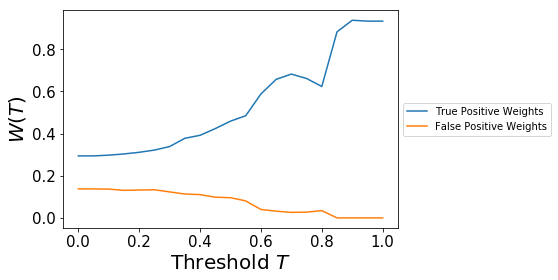

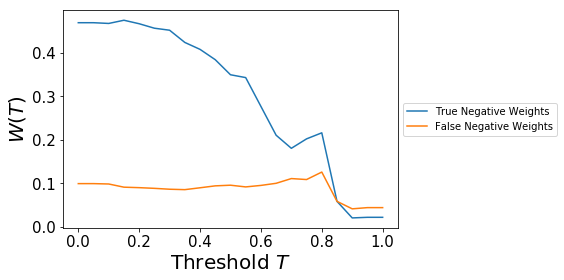

In [8]:
file_name="sentiment_model_tweet_test_scores.txt"
T, prob_tp,prob_fp, prob_tn,prob_fn, prob_pos, prob_neg = Vehicle_data.return_model_training_results_prob(file_name)


tp_norm = 1.0 #np.trapz(prob_tp*prob_pos, x=T)
fp_norm = 1.0 #np.trapz(prob_fp*prob_pos, x=T)

w_tp = prob_tp*prob_pos/tp_norm
w_fp = prob_fp*prob_pos/fp_norm


tn_norm = 1.0# np.trapz(prob_tn*prob_neg, x=T)
fn_norm = 1.0 #np.trapz(prob_fn*prob_neg, x=T)

w_tn = prob_tn*prob_neg/tn_norm
w_fn = prob_fn*prob_neg/fn_norm

plt.plot(T,w_tp,label="True Positive Weights")
plt.plot(T,w_fp,label="False Positive Weights")
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Threshold $T$",size=20)
plt.ylabel("$W(T)$",size=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(T,w_tn,label="True Negative Weights")
plt.plot(T,w_fn,label="False Negative Weights")
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Threshold $T$",size=20)
plt.ylabel("$W(T)$",size=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

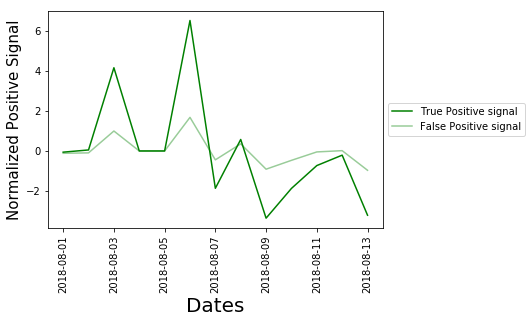

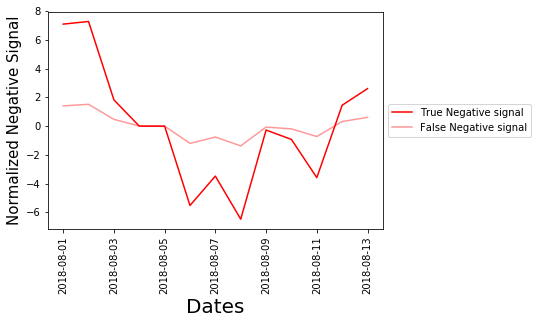

In [9]:
# Now We combine all of the curves

N =len(all_cars[0].car_data["Dates"])

dates = all_cars[0].car_data["Dates"]

y_pos_tot = np.zeros(N)
y_neg_tot = np.zeros(N)
y_neu_tot = np.zeros(N)

y_tp = np.zeros(N)
y_fp = np.zeros(N)

y_tn = np.zeros(N)
y_fn = np.zeros(N)

# Lopp over all thresholds
for k in range(len(all_cars)):
    #y_pos,y_neg,y_neu =all_cars[k].return_sentiment_data()
    y_pos,y_neg,y_neu =all_cars[k].scale_data_Ztransform()
    #y_pos,y_neg,y_neu =all_cars[k].scale_data_MinMaxTransform(Xmin=-1,Xmax=1)
    #y_pos,y_neg,y_neu =all_cars[k].daily_sentiment_return()

    #y_pos_tot += prob_pos[k]*prob_tp[k]*y_pos
    y_tp += w_tp[k]*y_pos
    y_fp += w_fn[k]*y_pos
    
    y_tn += w_tn[k]*y_neg
    y_fn += w_fn[k]*y_neg
    
plt.plot(dates,y_tp,label="True Positive signal",color="g")
plt.plot(dates,y_fp,label="False Positive signal",color="g",alpha=0.4)
plt.ylabel("Normalized Positive Signal",size=15)
plt.xticks(rotation='vertical')
plt.xlabel("Dates",size=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(dates,y_tn,label="True Negative signal",color="r")
plt.plot(dates,y_fn,label="False Negative signal",color="r",alpha=0.4)
plt.ylabel("Normalized Negative Signal",size=15)
plt.xticks(rotation='vertical')
plt.xlabel("Dates",size=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
# Load in all of the stock Data
data_tesla = pd.read_csv("stock_data/tesla.txt",delimiter=" ")
data_bmw = pd.read_csv("stock_data/bmw.txt",delimiter=" ")
data_toyota = pd.read_csv("stock_data/toyota.txt",delimiter=" ")
data_porsche = pd.read_csv("stock_data/porsche.txt",delimiter=" ")
data_daimler = pd.read_csv("stock_data/daimler.txt",delimiter=" ")
data_ford = pd.read_csv("stock_data/ford.txt",delimiter=" ")
data_sp500 = pd.read_csv("stock_data/SandP_500.txt",delimiter=" ")

# Remove the first date so as to match dimensions
y_tp=y_tp[1:]
y_tn=y_tn[1:]


if(target_car=="Toyota"):
    y_target_car=np.asarray(data_toyota["Closing_Price"])
    y_target_car=Vehicle_data().fill_NA_array(y_target_car)
elif(target_car=="Tesla"):
    y_target_car=np.asarray(data_tesla["Closing_Price"])
    y_target_car=Vehicle_data().fill_NA_array(y_target_car)
elif(target_car=="BMW"):
    y_target_car=np.asarray(data_bmw["Closing_Price"])
    y_target_car=Vehicle_data().fill_NA_array(y_target_car)
elif(target_car=="Porsche"):
    y_target_car=np.asarray(data_porsche["Closing_Price"])
    y_target_car=Vehicle_data().fill_NA_array(y_target_car)
elif(target_car=="Mercedes"):
    y_target_car=np.asarray(data_daimler["Closing_Price"])
    y_target_car=Vehicle_data().fill_NA_array(y_target_car)
elif(target_car=="Ford"):
    y_target_car=np.asarray(data_ford["Closing_Price"])
    y_target_car=Vehicle_data().fill_NA_array(y_ford)   
    
# Read in the S and P 500 data
y_sp500=np.asarray(data_sp500["Closing_Price"])
y_sp500=Vehicle_data().fill_NA_array(y_sp500)

# Convert values to daily returns
daily_return_target_car=(y_target_car[1:]/y_target_car[0:-1])-1.0
daily_return_sp500=(y_sp500[1:]/y_sp500[0:-1])-1.0

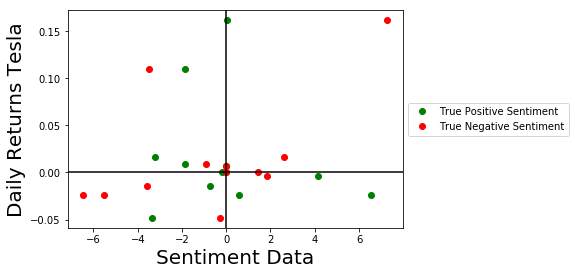

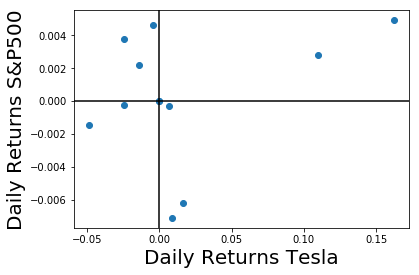

In [11]:
plt.plot(y_tp,daily_return_target_car,"o",c="g",label="True Positive Sentiment")
plt.plot(y_tn,daily_return_target_car,"o",c="r",label="True Negative Sentiment")
plt.axvline(x=0, color='k')
plt.axhline(y=0, color='k')
plt.ylabel("Daily Returns "+target_car,size=20)
plt.xlabel("Sentiment Data",size=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(daily_return_target_car,daily_return_sp500,"o")
plt.axvline(x=0, color='k')
plt.axhline(y=0, color='k')
plt.ylabel("Daily Returns S&P500",size=20)
plt.xlabel("Daily Returns "+target_car,size=20)
plt.show()

In [ ]:
import dynesty
import scipy.optimize as op

alpha_min, alpha_max = -100.0, 100.0
b1_min, b1_max = -10.0, 10.0
b2_min, b2_max = -10.0, 10.0
b3_min, b3_max = -10.0, 10.0
sigma_min, sigma_max = 1.0e-10, 2

data_dict = {}
data_dict["y"]=daily_return_target_car
data_dict["x1"]=y_tp
data_dict["x2"]=y_tn
data_dict["x3"]=daily_return_sp500


def line_model(x1,x2,x3,alpha,b1,b2,b3):
    
    y = alpha +b1*x1+b2*x2+b3*x3
    return y

def prior_transform(utheta):
    
    u_alpha, u_b1,u_b2,u_b3,u_sigma = utheta # these are samples from the unit hyper cube
    # the "prior transform" below maps the unit-cube samples to the 
    # parameters we care about 
    
    # Think of this as the result of performing the inverse CDF. The 
    #specific mapping here maps uniformly distributed samples 
    #(on the hypercube) to uniformly distributed samples
    # on the correct intervals
    
    alpha = (alpha_max - alpha_min) * u_alpha + alpha_min
    b1 = (b1_max - b1_min) * u_b1 + b1_min
    b2 = (b2_max - b2_min) * u_b2 + b2_min
    b3 = (b3_max - b3_min) * u_b3 + b3_min
    sigma = (sigma_max - sigma_min) * u_sigma + sigma_min
    
    return alpha, b1, b2,b3,sigma


def ln_like_for_nest(theta):
    
    alpha = theta[0]
    b1 = theta[1]
    b2 = theta[2]
    b3 = theta[3]
    sigma = theta[4]
    
    # Retrieve the data
    x1_data = data_dict['x1']
    x2_data = data_dict['x2']
    x3_data = data_dict['x3']
    y_data = data_dict['y']
    
    inv_sigma2 = 1.0/sigma**2
    
    model = line_model(x1,x2,x3,alpha,b1,b2,b3)
    
    lnL = -0.5*(np.sum((y_data-model)**2*inv_sigma2 - np.log(inv_sigma2)))

    
    return lnL


nll = lambda *args: -ln_like_for_nest(*args)

x1 = y_tp
x2 = y_tn
x3 = daily_return_sp500
y = daily_return_target_car

result = op.minimize(nll, [2.0,2.0,-1.0,6.0,1.0])

m_ml, b1_ml,b2_ml,b3_ml,sigma_ml = result["x"]

print("Optimized Estimates: ", m_ml,b1_ml,b2_ml,b3_ml,sigma_ml)


dsampler = dynesty.NestedSampler(ln_like_for_nest, prior_transform, ndim=5,
                                  nlive=1000)
dsampler.run_nested(dlogz=0.01)
dres = dsampler.results

Optimized Estimates:  0.017309478765 -0.00874134001019 0.00654163706176 9.06763173398 0.0418410464042


iter: 23522 | bound: 8076 | nc: 7003 | ncall: 7456162 | eff(%):  0.315 | loglstar:   -inf < 23.081 <    inf | logz: -0.655 +/-  0.149 | dlogz:  8.401 >  0.010               

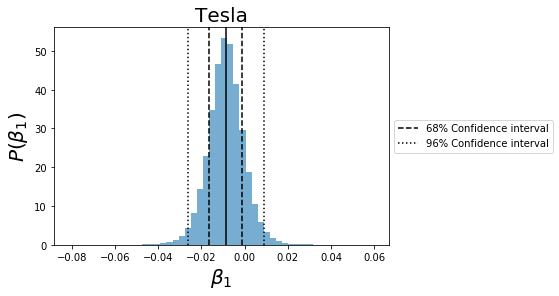

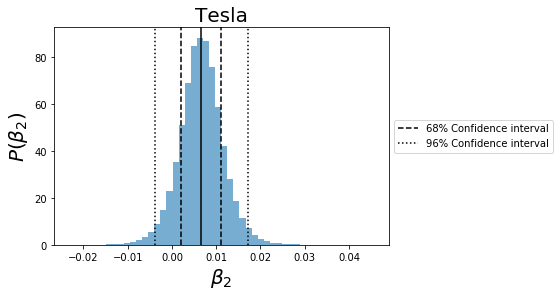

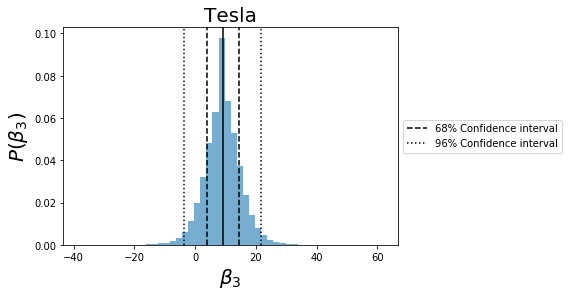

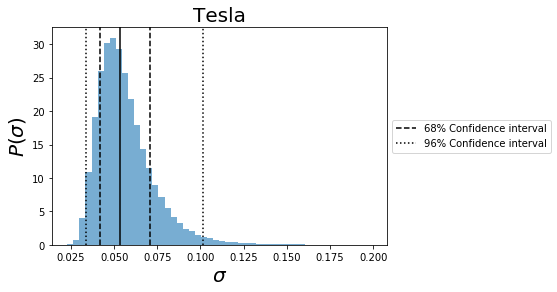

In [12]:
s=samples[:,1]
median, q1, q3,q4,q5 = np.percentile(s, 50), np.percentile(s, 16), np.percentile(s, 84), np.percentile(s,2),np.percentile(s,98)
plt.axvline(x=median, color='k')
plt.axvline(x=q1, color='k',linestyle="--",label="68% Confidence interval")
plt.axvline(x=q3, color='k',linestyle="--")
plt.axvline(x=q4, color='k',linestyle=":",label="96% Confidence interval")
plt.axvline(x=q5, color='k',linestyle=":")
plt.ylabel(r"$P(\beta_1 )$", size=20)
plt.xlabel(r"$\beta_1$", size=20)
plt.hist(s,bins=50,density=True,alpha=0.6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(target_car,size=20)
plt.show()

s=samples[:,2]
median, q1, q3,q4,q5 = np.percentile(s, 50), np.percentile(s, 16), np.percentile(s, 84), np.percentile(s,2),np.percentile(s,98)
plt.axvline(x=median, color='k')
plt.axvline(x=q1, color='k',linestyle="--",label="68% Confidence interval")
plt.axvline(x=q3, color='k',linestyle="--")
plt.axvline(x=q4, color='k',linestyle=":")
plt.axvline(x=q5, color='k',linestyle=":",label="96% Confidence interval")
plt.ylabel(r"$P(\beta_2 )$", size=20)
plt.xlabel(r"$\beta_2$", size=20)
plt.hist(s,bins=50,density=True,alpha=0.6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(target_car,size=20)
plt.show()

s=samples[:,3]
median, q1, q3,q4,q5 = np.percentile(s, 50), np.percentile(s, 16), np.percentile(s, 84), np.percentile(s,2),np.percentile(s,98)
plt.axvline(x=median, color='k')
plt.axvline(x=q1, color='k',linestyle="--",label="68% Confidence interval")
plt.axvline(x=q3, color='k',linestyle="--")
plt.axvline(x=q4, color='k',linestyle=":")
plt.axvline(x=q5, color='k',linestyle=":",label="96% Confidence interval")
plt.ylabel(r"$P(\beta_3)$", size=20)
plt.xlabel(r"$\beta_3$", size=20)
plt.hist(s,bins=50,density=True,alpha=0.6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(target_car,size=20)
plt.show()

#fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
s=samples[:,4]
median, q1, q3,q4,q5 = np.percentile(s, 50), np.percentile(s, 16), np.percentile(s, 84), np.percentile(s,2),np.percentile(s,98)
plt.axvline(x=median, color='k')
plt.axvline(x=q1, color='k',linestyle="--",label="68% Confidence interval")
plt.axvline(x=q3, color='k',linestyle="--")
plt.axvline(x=q4, color='k',linestyle=":")
plt.axvline(x=q5, color='k',linestyle=":",label="96% Confidence interval")
plt.ylabel(r"$P(\sigma)$", size=20)
plt.xlabel(r"$\sigma$", size=20)
plt.hist(s,bins=50,density=True,alpha=0.6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(target_car,size=20)
plt.show()

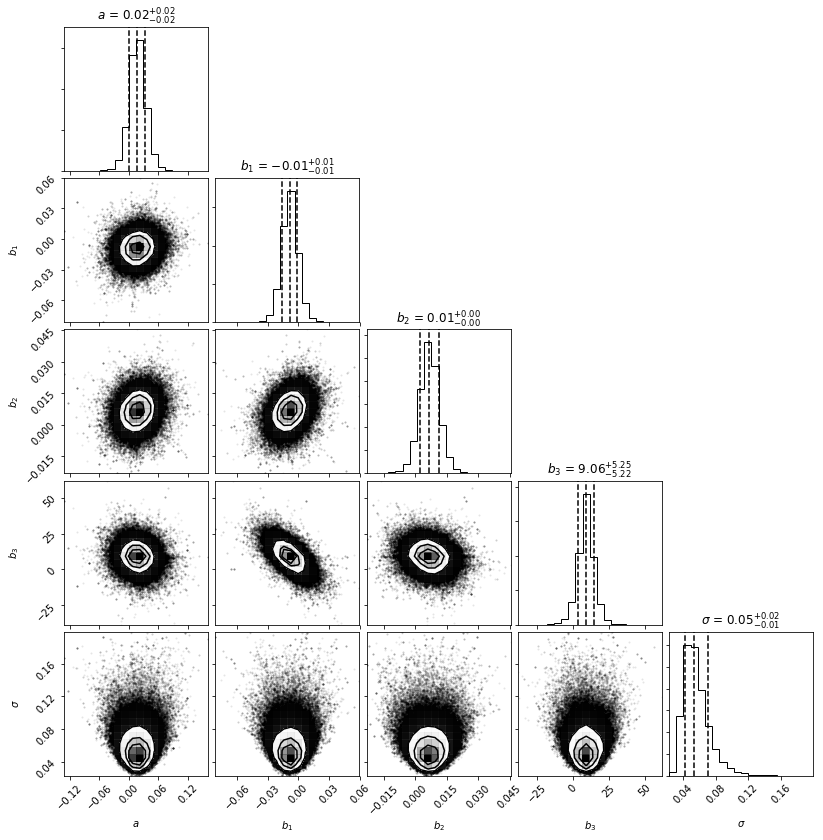

In [9]:
import corner
fig = corner.corner(samples,labels=["$a$", "$b_1$","$b_2$","$b_3$","$\sigma$"], quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12})

In [10]:
a_mcmc, b1_mcmc,b2_mcmc,b3_mcmc,sigma_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0],v[4]-v[1],v[1]-v[3]),
                             zip(*np.percentile(samples, [16, 50, 84,2,98],
                                                axis=0)))

print("====================================================\n")
print("Parameter estimation for: "+ target_car+"\n")

print("The 68% Confidence regions")
print("a_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
print("b1_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(b1_mcmc[0],b1_mcmc[1],b1_mcmc[2]))
print("b2_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(b2_mcmc[0],b2_mcmc[1],b2_mcmc[2]))
print("b3_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(b3_mcmc[0],b3_mcmc[1],b3_mcmc[2]))
print("sigma_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(sigma_mcmc[0],sigma_mcmc[1],sigma_mcmc[2]))

print("\n")
print("The 96% Confidence regions")
print("a_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(a_mcmc[0],a_mcmc[3],a_mcmc[4]))
print("b1_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(b1_mcmc[0],b1_mcmc[3],b1_mcmc[4]))
print("b2_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(b2_mcmc[0],b2_mcmc[3],b2_mcmc[4]))
print("b3_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(b3_mcmc[0],b3_mcmc[3],b3_mcmc[4]))
print("sigma_mcmc = %.04f ^{+%0.03f}_{-%0.03f}"%(sigma_mcmc[0],sigma_mcmc[3],sigma_mcmc[4]),"\n")

print("Correlation between B1 and B2:", np.corrcoef(samples[:,1], (samples[:,2]))[0,1])
print("====================================================\n")


Parameter estimation for: Tesla

The 68% Confidence regions
a_mcmc = 0.0169 ^{+0.016}_{-0.016}
b1_mcmc = -0.0086 ^{+0.008}_{-0.008}
b2_mcmc = 0.0066 ^{+0.005}_{-0.005}
b3_mcmc = 9.0618 ^{+5.253}_{-5.215}
sigma_mcmc = 0.0533 ^{+0.017}_{-0.011}


The 96% Confidence regions
a_mcmc = 0.0169 ^{+0.038}_{-0.037}
b1_mcmc = -0.0086 ^{+0.018}_{-0.018}
b2_mcmc = 0.0066 ^{+0.011}_{-0.011}
b3_mcmc = 9.0618 ^{+12.514}_{-12.558}
sigma_mcmc = 0.0533 ^{+0.048}_{-0.020} 

Correlation between B1 and B2: 0.298286048601



# Examine the residuals of the linear regression model

residual mean 0.0005
residual std 0.0418


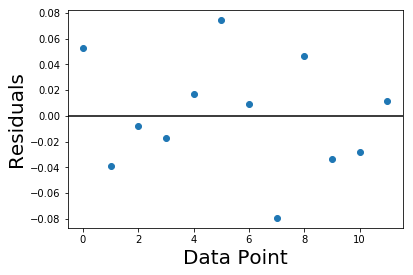

In [11]:
model = a_mcmc[0]+b1_mcmc[0]*x1+b2_mcmc[0]*x2 +b3_mcmc[0]*x3     
res = (y-model)

print("residual mean %.04f"%res.mean())
print("residual std %.04f"%res.std())

plt.plot(res,"o")
plt.ylabel("Residuals",size=20)
plt.xlabel("Data Point", size=20)
plt.axhline(y=0, color='k')
plt.show()